## Machine Learning Record Mining

Project to create a pipeline that uses GeoDeepDive's output to find Unaquired Sites for Neotoma.

Using NLP parsed text and a Data Science approach, identify whether a paper is suitable for Neotoma and detect features such as 'Site Name', 'Location', 'Age Span' and 'Site Descriptions'.

In [1]:
# Loading libraries

import numpy as np
import pandas as pd
import csv
import psycopg2
import re
import ast
import os

#Output path for generated files
path = r'/Users/seiryu8808/Desktop/UWinsc/Github/UnacquiredSites/src/output'

# Loading libraries for modeling
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

import re
from collections import defaultdict
from collections import Counter

In [2]:
import src.modules.preprocessing.nlp_sentence_loader as sentence_loader
import src.modules.preprocessing.bibliography_loader as bib_loader
import src.modules.preprocessing.add_regex_degrees as ard

In [3]:
# Options for DF display
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_rows', 10)

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)

## Loading and viewing the Data

### Loading NLP Sentences

In [4]:
nlp_sentences = sentence_loader.preprocessed_sentences_sql()

Data obtained from PostgreSQL


In [5]:
nlp_sentences.head(3)

,_gddid,sentid,wordidx,words,part_of_speech,special_class,lemmas,word_type,word_modified,words_as_string,dms_regex,dd_regex,digits_regex,words_l
0,54b43266e138239d8684efed,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[Available, online, at, www.sciencedirect.com,...","[JJ, NN, IN, NNP, NNP, NNP, CD, -LRB-, CD, -RR...","[O, O, O, O, O, O, NUMBER, O, DATE, O, NUMBER,...","[available, online, at, www.sciencedirect.com,...","[dep, dep, dep, dep, dep, dep, dep, , dep, , d...","[218, 218, 218, 218, 218, 218, 218, 0, 218, 0,...","Available,online,at,www.sciencedirect.com,Quat...",[],[],"[69, 2008, 263, 275, 1, 2, 5694, 86011, 6013, ...","[available, online, at, www.sciencedirect.com,..."
1,54b43266e138239d8684efed,2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[The, Chihuahueños, Bog, record, extends, to, ...","[DT, NNP, NN, NN, VBZ, TO, IN, CD, JJ, NN, NN, .]","[O, O, O, O, O, O, O, NUMBER, O, DURATION, O, O]","[the, Chihuahueños, bog, record, extend, to, o...","[det, compound, compound, nsubj, , case, amod,...","[4, 4, 4, 5, 0, 11, 11, 11, 11, 11, 5, 0]","The,Chihuahueños,Bog,record,extends,to,over,15...",[],[],"[15, 000]","[the, chihuahueños, bog, record, extends, to, ..."
2,54b43266e138239d8684efed,3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[An, Artemisia, steppe, ,, then, an, open, Pic...","[DT, NNP, NN, ,, RB, DT, JJ, NNP, NN, VBD, IN,...","[O, O, O, O, O, O, O, LOCATION, LOCATION, O, O...","[a, Artemisia, steppe, ,, then, a, open, Picea...","[det, compound, nsubj, , advmod, det, amod, co...","[3, 3, 10, 0, 9, 9, 9, 9, 10, 0, 14, 14, 14, 1...","An,Artemisia,steppe,,,then,an,open,Picea,woodl...",[],[],"[11, 700]","[an, artemisia, steppe, ,, then, an, open, pic..."


In [6]:
# Running this takes forever. Do not run unless necessary
# nlp_sentences.describe(include = 'all')

In [7]:
avg_sentences = nlp_sentences.groupby('_gddid')['_gddid','sentid'].transform('max')
avg_sentences.drop_duplicates(subset='_gddid', keep='first', inplace=True)
avg_sentences.describe()

,sentid
count,218.000000
mean,513.600917
std,232.460891
min,2.000000
25%,397.250000
50%,504.000000
75%,638.250000
max,1330.000000


From the Summary Statistics, despite having 111,965 sentences, there are only 218 unique articles (`_gddid`). The article with most sentences, had 1330 sentences; that's the max number found in `sentid`.  
In order to know the average of sentences, I grouped by `_gddid` and then, obtained the number of sentences per article. After that, I just got the mean through a Summary of statistics to know that on average, each article has 514 sentences.

### Loading Bibliography Data

In [8]:
bibliography = bib_loader.preprocessed_bibliography()

In [9]:
bibliography.head(3)

,_type,doi,publisher,title,journal.name.name,author,year,number,volumne,_gddid,type,pages,link_url,link_type
0,doi,10.1016/S0277-3791(99)00007-4,Elsevier,"Palaeoclimate, chronology and vegetation histo...",Quaternary Science Reviews,"Huntley, B.; Watts, W.A.; Allen, J.R.M.; Zolit...",1999,7,NaN,550453fde1382326932d85f7,article,945--960,http://www.sciencedirect.com/science/article/p...,publisher
1,doi,10.1139/b92-002,Canadian Science Publishing,Holocene history of forest trees on the Bruce ...,Canadian Journal of Botany,"Bennett, K. D.",1992,1,NaN,578b5aabcf58f1587003efba,article,6--18,http://www.nrcresearchpress.com/doi/abs/10.113...,publisher
2,doi,10.1016/0031-0182(80)90043-7,Elsevier,Glacial sequence and environmental history in ...,"Palaeogeography, Palaeoclimatology, Palaeoecology","Van Der Hammen, T.; Barelds, J.; De Jong, H.; ...",1980,NaN,NaN,54b43244e138239d868493cd,article,247--340,http://www.sciencedirect.com/science/article/p...,publisher


In [10]:
bibliography.describe(include = 'all')

,_type,doi,publisher,title,journal.name.name,author,year,number,volumne,_gddid,type,pages,link_url,link_type
count,221,221,221,221,221,221,221,183,0,221,221,216,221,220
unique,1,221,6,221,41,213,47,28,0,221,1,214,221,1
top,doi,10.1111/j.1365-2699.2004.01143.x,Elsevier,Vegetation and climates in southern Tasmania s...,Quaternary Research,"Markgraf, Vera",2011,3,NaN,5507ab96e1382326932d966e,article,1--13,http://www.nrcresearchpress.com/doi/abs/10.113...,publisher
freq,221,1,138,1,44,3,14,40,NaN,1,221,2,1,220


## EDA

Reviewing our data includes skimming through some papers online and seeing if the data is consistent with our NLP Sentences dataframe.

From there, we can also visualize what we would like our model to predict: 'Location', 'Site Name', 'Age Span', and 'Site Description' from a "Human perspective".

### Finding Latitude and Longitud via REGEX 

After reviewing some PDF's and viewing the data parsing, I noticed some possible patterns for coordinates.

<img src="figures/img/00_snippet_of_pdf.png" alt="Drawing" style="width: 300px;"/>

Which translates to our pandas dataframe as:

![alt text](figures/img/01_snippet_in_sql.png "PandasVersion")

As a first problem, we can notice that the degrees symbol `°` was translated as a `3`. On some other occassions, it is confused as an `o` or a middle point `◦`. For `'`, this symbol got confused by the word `cents`.

I am still going to use normal REGEX to find coordinates in the most intuitive way. 

A coordinate for longitude is a number ranging from -180° to 180°. It has three components, `°, ',"` and it covers the position in E or W.

Latitude goes from -90° to 90°, has the same three components and goes from S to N.

Using REGEX, and assuming data consistency, the following code should be able to extract coordinates. 

In [11]:
# TODO Find REGEX of couples of numbers (123, 234)
nlp_sentences[['words_as_string', 'words', 'dms_regex', 'dd_regex']].head(3)

,words_as_string,words,dms_regex,dd_regex
0,"Available,online,at,www.sciencedirect.com,Quat...","[Available, online, at, www.sciencedirect.com,...",[],[]
1,"The,Chihuahueños,Bog,record,extends,to,over,15...","[The, Chihuahueños, Bog, record, extends, to, ...",[],[]
2,"An,Artemisia,steppe,,,then,an,open,Picea,woodl...","[An, Artemisia, steppe, ,, then, an, open, Pic...",[],[]


In [12]:
# Run only when enough time available
# nlp_sentences[['words_as_string', 'words', 'dms_regex', 'dd_regex']].describe()

The `dms_regex` only returned 95 unique values. That's to say that from the 111965 sentences, only 95 possess something similar to the regex we are looking for.  However, the `dd_regex` returned 8 values.

Let's see an example of each regex extraction to verify values.

In [13]:
# dms regex example
dms_example = nlp_sentences[nlp_sentences['_gddid'] == '550453fde1382326932d85f7']
dms_example = dms_example[dms_example['sentid'] == 10]
dms_example[['words', 'words_as_string', 'dms_regex', 'dd_regex']]

,words,words_as_string,dms_regex,dd_regex
94875,"[Introduction, Laghi, di, Monticchio, are, two...","Introduction,Laghi,di,Monticchio,are,two,maar,...","[403,56,40,N,,,153,36,48,E]",[]


In [14]:
# dd_regex example
dd_example = nlp_sentences[nlp_sentences['_gddid'] == '57a12aaccf58f1b0962a836c']
dd_example = dd_example[dd_example['sentid'] == 62]
dd_example[['words', 'words_as_string', 'dms_regex', 'dd_regex']]

,words,words_as_string,dms_regex,dd_regex
62439,"[Kingston, meadow, Kingston, Meadow, -LRB-, 24...","Kingston,meadow,Kingston,Meadow,-LRB-,2400,m,e...",[],"[117.11,W,39.21,N]"


### Problems with the REGEX approach

As seen before, extracting information using REGEX is very complicated. We would require a lot of queries that would retrieve each particular case.

A possible alternative could be using NER, Named Entity Recognition.

Article 01  
Skimmed info: 
 * `Article Name:` Palaeoclimate_chronology_and_vegetation_history_of_the_Weichselian_Lateglacial
 * `Link`: http://www.sciencedirect.com/science/article/pii/S0277379199000074  
 * `Site Name`:  Laghi di Monticchio
 * `Location`:  40° 56' 40" N, 15° 36' 48" E
 * `Age Span`: 
 * `Site Descriptions`: The record from Lago Grande di Monticchio now adds macrofossil evidence of the presence of relatively boreal tree taxa during the Lateglacial interstadial and provides a chronology based upon annually laminated sediments.

In [15]:
# Article 01 
ard.order_article(nlp_sentences, '550453fde1382326932d85f7')

,sentid,words
94865,1,"[Quaternary, Science, Reviews, 18, -LRB-, 1999..."
94866,2,"[Plant, macrofossil, data, from, one, core, pr..."
94867,3,"[Quantitative, palaeoclimate, reconstructions,..."
94868,4,"[The, chronological, framework, for, Lateglaci..."
94870,5,"[Surface, conditions, in, the, North, Atlantic..."
...,...,...
95325,448,"[Vegetation, history, and, climate, of, the, l..."
95326,449,"[Quaternary, Science, Reviews, ,, 15, ,, 133, ..."
95327,450,"[Zolitschka, ,, B., ,, &, Negendank, ,, J., F...."
95329,451,"[Sedimentology, ,, dating, and, palaeoclimatic..."


Article 02  
Skimmed info:  
* `Article:` Development of the Mixed Connifer Forest in Northern New Mexico and its relationship to Holocene environmental change
* `Link`: http://www.sciencedirect.com/science/article/pii/S0033589407001512
* `Site Name`:  Chihuahuenos Bog 
* `Location`:  ??? No Given Coordinates 
* `Age Span`:   
* `Site Descriptions`:  Chihuahueños Bog is located within the mixed conifer forest and has affinities to the flora of the southern Rocky Mountains(Foxx and Tierney, 1985; Allen, 2004). Although the area immediately surrounding the bog has been heavily logged in recent years, nearly every conifer species growing in montaneforests of the Jemez mountains is represented either along theshore of the bog or in the surrounding uplands.  

In [16]:
# Article 2
# ard.order_article(nlp_sentences, '54b43266e138239d8684efed')

Article 03  
Skimmed info:  
* `Link`: http://dx.doi.org/10.1130/g35541.1  # No Full access to article
* `Site Name`:  Cahokia region, Illinois, USA
* `Location`:  N38°42'00" - N38°42'00", W90°04'60" - W90°04'60" - Not found on text (yet).
* `Age Span`:   
* `Site Descriptions`: Record from Horseshoe Lake, an oxbow lake in the central Mississippi River valley that is adjacent to the Cahokia site (Illinois, USA), the largest prehistoric settlement north of Mexico.   

In [17]:
# Article 3
# ard.order_article(nlp_sentences, '57c5b941cf58f1338eaddb5b')

Article 04  
Skimmed info:  
* `Link:`http://www.tandfonline.com/doi/abs/10.1080/00173130902965157
* `Site Name`:  Begbunar
* `Location`:  42°09′ N, 22° 33′ E; 1750 ; in SQL file shows as: `42,°,09,cents,N,,,22,°,33,cents,E`
* `Age Span`:   
* `Site Descriptions`: Located in the central treeless zone of the Osogovo mountains, which are situated at the border between south-western Bulgaria and the north-eastern former Yugoslav Republic of Macedonia.

In [18]:
# Article 4
# ard.order_article(nlp_sentences, '58d29193cf58f14928755ba5')

In [19]:
# Try to see the exact location. Wont show last few words.
# pd.DataFrame(ard.order_article(nlp_sentences,'58d29193cf58f14928755ba5').iloc[4]['words'])

Article 05  
Skimmed info:  
* `Link`: http://dx.doi.org/10.1130/0016-7606(1997)109<1306:tfalqp>2.3.co
* `Site Name`:  Cottonwood III, Cottonwood IV, Red Lady, Red Well, Splains
* `Location`:  38°49'50' 106°24'45', 38°49'50' 106°24'45', 38°52'50' 107°2'30', 38°52'50' 107°2'30',38°53'40' 107°3'15', 38°52'28' 107°05', 38°50' 107°4'30', 38°50' 107°4'30', 38°52' 107°2'30', 38°45' 106°50', 38°45' 106°50'
* `Age Span`:   17000 - 400
* `Site Descriptions`:   The lower timberline or lower forest border is the lower elevational limit of a continuous forest belt. In the Rocky Mountains it forms a sharp contrast with shrublands or grasslands in valley bottoms. Trees may extend below the lower timberline in favorable habitats, along streams or on rocky outcrops.  

In [20]:
# Article 5
# ard.order_article(nlp_sentences, '57928e07cf58f133d1c26609')

In [21]:
# Print the exact line where locations are.
# pd.DataFrame(ard.order_article(nlp_sentences, '57928e07cf58f133d1c26609').iloc[179])

## Linking Neotoma DB to extract locations

In [22]:
import src.modules.preprocessing.neotoma_loader as nl

In [23]:
neotoma = nl.neotoma_loader()

In [24]:
neotoma.head(3)

,siteid,sitename,longitudeeast,latitudenorth,longitudewest,latitudesouth,sitedescription,doi
0,10330,Lac du Sommet,-70.66468,47.71662,-70.66573,47.71382,"The small shallow Lac du Sommet (0.02 km2, 4 m...",10.1177/0959683611400199
1,10330,Lac du Sommet,-70.66468,47.71662,-70.66573,47.71382,"The small shallow Lac du Sommet (0.02 km2, 4 m...",10.1177/0959683611400199
2,1729,Myrtle Lake,-93.37853,47.98645,-93.39207,47.97876,Lake surrounded by peatland. Physiography: Red...,10.1139/b68-190


In [25]:
nlp_bib = nlp_sentences.merge(bibliography, on = '_gddid')
nlp_bib.head(3)

,_gddid,sentid,wordidx,words,part_of_speech,special_class,lemmas,word_type,word_modified,words_as_string,...,title,journal.name.name,author,year,number,volumne,type,pages,link_url,link_type
0,54b43266e138239d8684efed,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[Available, online, at, www.sciencedirect.com,...","[JJ, NN, IN, NNP, NNP, NNP, CD, -LRB-, CD, -RR...","[O, O, O, O, O, O, NUMBER, O, DATE, O, NUMBER,...","[available, online, at, www.sciencedirect.com,...","[dep, dep, dep, dep, dep, dep, dep, , dep, , d...","[218, 218, 218, 218, 218, 218, 218, 0, 218, 0,...","Available,online,at,www.sciencedirect.com,Quat...",...,Development of the mixed conifer forest in nor...,Quaternary Research,"Anderson, R. Scott; Jass, Renata B.; Toney, Ja...",2008,2,NaN,article,263--275,http://www.sciencedirect.com/science/article/p...,publisher
1,54b43266e138239d8684efed,2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[The, Chihuahueños, Bog, record, extends, to, ...","[DT, NNP, NN, NN, VBZ, TO, IN, CD, JJ, NN, NN, .]","[O, O, O, O, O, O, O, NUMBER, O, DURATION, O, O]","[the, Chihuahueños, bog, record, extend, to, o...","[det, compound, compound, nsubj, , case, amod,...","[4, 4, 4, 5, 0, 11, 11, 11, 11, 11, 5, 0]","The,Chihuahueños,Bog,record,extends,to,over,15...",...,Development of the mixed conifer forest in nor...,Quaternary Research,"Anderson, R. Scott; Jass, Renata B.; Toney, Ja...",2008,2,NaN,article,263--275,http://www.sciencedirect.com/science/article/p...,publisher
2,54b43266e138239d8684efed,3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[An, Artemisia, steppe, ,, then, an, open, Pic...","[DT, NNP, NN, ,, RB, DT, JJ, NNP, NN, VBD, IN,...","[O, O, O, O, O, O, O, LOCATION, LOCATION, O, O...","[a, Artemisia, steppe, ,, then, a, open, Picea...","[det, compound, nsubj, , advmod, det, amod, co...","[3, 3, 10, 0, 9, 9, 9, 9, 10, 0, 14, 14, 14, 1...","An,Artemisia,steppe,,,then,an,open,Picea,woodl...",...,Development of the mixed conifer forest in nor...,Quaternary Research,"Anderson, R. Scott; Jass, Renata B.; Toney, Ja...",2008,2,NaN,article,263--275,http://www.sciencedirect.com/science/article/p...,publisher


In [26]:
#print(nlp_bib.shape)

In [27]:
nlp_bib[['words_as_string', 'journal.name.name', 'dms_regex', 'dd_regex']].head(3)

,words_as_string,journal.name.name,dms_regex,dd_regex
0,"Available,online,at,www.sciencedirect.com,Quat...",Quaternary Research,[],[]
1,"The,Chihuahueños,Bog,record,extends,to,over,15...",Quaternary Research,[],[]
2,"An,Artemisia,steppe,,,then,an,open,Picea,woodl...",Quaternary Research,[],[]


In [28]:
neotoma_joined_df = nl.grouped_coords_df(neotoma)

In [29]:
neotoma_joined_df.head(2)

,doi,sitenames,siteid,longeast,latnorth,sitenames_l
0,0.1139/e80-122,"[East Baltic Bog, Mermaid Bog, Portage Bog]","[763, 1684, 1903]","[64, 63, 62]",[46],"[bog, east, baltic, portage, mermaid]"
1,10.1002/(SICI)1099-1417(199607/08)11:4<327::AI...,[Lundin Tower],[3256],[2],[56],"[lundin, tower]"


From Neotoma DB, we have obtained a dataframe grouped by DOI that lists each `sitename`, `siteid`, `longitude east`, and `latitunde north`. Now, let's join this information to the NLP_Bib dataframe. For now, let's do to the one that coordinates have been obtained with REGEX just to see if some of the numbers and sitenames make sense. 

In [30]:
nlp_bib_neotoma = nlp_bib.merge(neotoma_joined_df, on = 'doi', how = 'left')
print(nlp_bib_neotoma.shape)

(111965, 32)


In [31]:
articles_not_referenced_to_in_neotoma = nlp_bib_neotoma[nlp_bib_neotoma['longeast'].isnull()]
articles_not_referenced_to_in_neotoma = articles_not_referenced_to_in_neotoma.groupby('_gddid')\
                                                                             .agg({'longeast':'sum'})

articles_not_referenced_to_in_neotoma = articles_not_referenced_to_in_neotoma.merge(bibliography, on ='_gddid')
articles_not_referenced_to_in_neotoma = articles_not_referenced_to_in_neotoma[['_gddid', 'title', 'year', 'doi', 'link_url']]
articles_not_referenced_to_in_neotoma.describe()

,_gddid,title,year,doi,link_url
count,14,14,14,14,14
unique,14,14,12,14,14
top,578ab0becf58f1266e59a633,Extinct mountain goat (Oreamnos harringtoni) i...,1987,10.1130/0016-7606(1968)79[855:psamao]2.0.co;2,http://dx.doi.org/10.1130/0091-7613(1993)021<0...
freq,1,1,2,1,1


We can see there are 14 articles that we do not have reference for in Neotoma DB.

For these 14 articles, we have no coordinates to compare to.

In [32]:
neotoma[neotoma['doi']=='10.1016/S0031-0182(01)00322-4']

,siteid,sitename,longitudeeast,latitudenorth,longitudewest,latitudesouth,sitedescription,doi


In [33]:
# Export file with no coordinates in Neotoma
output_file = os.path.join(path,'articles_wo_neotoma_coordinates.tsv')
articles_not_referenced_to_in_neotoma.to_csv(output_file, sep='\t', index = False)

In [34]:
# Drop rows with na
nlp_bib_neotoma = nlp_bib.merge(neotoma_joined_df, on = 'doi')
print(nlp_bib_neotoma.shape)

(106640, 32)


In [35]:
# Filter df to just frames that has REGEX longer than one
mask = ((nlp_bib_neotoma['dms_regex'].str.len() > 0) | (nlp_bib_neotoma['dd_regex'].str.len() > 0))
nlp_bib_neotoma_regex = nlp_bib_neotoma.loc[mask]
print(nlp_bib_neotoma_regex.shape)

nlp_bib_neotoma_regex[['words','dms_regex', 'dd_regex']].head(100)

(100, 32)


,words,dms_regex,dd_regex
3314,"[Lake, Hope, Simpson, -LRB-, 52, ', 27, ', N, ...","[52,',27,',N,,,56,',26,',W]",[]
3318,"[The, lake, basin, itself, has, an, irregular,...","[52,',33,',N,,,56,',54,',W]",[]
3320,"[Moraine, Lake, -LRB-, 52, ', 16, ', N, ,, 58,...","[52,',16,',N,,,58,',03,',W]",[]
3324,"[St., Paul, Lake, -LRB-, 52, ', 05, ', N, ,, 5...","[52,',05,',N,,,57,',50,',W]",[]
3408,"[Diagram, of, pollen, percentages, -LRB-, abov...","[52,',16,',N,,,58,',03,',W]",[]
...,...,...,...
99874,"[Introduction, Laghi, di, Monticchio, are, two...","[403,56,40,N,,,153,36,48,E]",[]
102724,"[Within, the, basin, ,, members, of, the, DeFo...","[410,45,',N,410,40,',, 90,0,45,',90,0,40,',, 9...",[]
104155,"[Nothofagus, antarctica, ,, Pilgerodendron, uv...","[710,26,',W,410,44,'S]",[]
104959,"[doi, :10.1016, /, j.yqres, .2006.08.006, 298,...","[41,°,00,′,N,,,74,°,55,′,W]",[]


In [36]:
# nlp_bib_neotoma_regex.describe(include='all')

In [53]:
nlp_bib_neotoma_regex = nlp_bib_neotoma_regex[['_gddid', 'sentid', 'doi', 'words', 'words_as_string', 'dms_regex', 'dd_regex', 'sitenames', 'latnorth', 'longeast']].reset_index()
nlp_bib_neotoma_regex.head(3)

,index,_gddid,sentid,doi,words,words_as_string,dms_regex,dd_regex,sitenames,latnorth,longeast
0,0,578a1f6ecf58f1b54b810cd9,94,10.1139/b85-070,"[Lake, Hope, Simpson, -LRB-, 52, ', 27, ', N, ...","Lake,Hope,Simpson,-LRB-,52,',27,',N,,,56,',26,...","[52,',27,',N,,,56,',26,',W]",[],"[Lake Hope Simpson, 18 [Moraine Lake]]",[52],"[56, 58]"
1,1,578a1f6ecf58f1b54b810cd9,97,10.1139/b85-070,"[The, lake, basin, itself, has, an, irregular,...","The,lake,basin,itself,has,an,irregular,though,...","[52,',33,',N,,,56,',54,',W]",[],"[Lake Hope Simpson, 18 [Moraine Lake]]",[52],"[56, 58]"
2,2,578a1f6ecf58f1b54b810cd9,99,10.1139/b85-070,"[Moraine, Lake, -LRB-, 52, ', 16, ', N, ,, 58,...","Moraine,Lake,-LRB-,52,',16,',N,,,58,',03,',W,,...","[52,',16,',N,,,58,',03,',W]",[],"[Lake Hope Simpson, 18 [Moraine Lake]]",[52],"[56, 58]"


We can see that most of the REGEX indeed pulled out the same locations for latitude and longitudes as in the Neotoma database.

In [54]:
nlp_bib_neotoma[['_gddid', 'sentid', 'doi', 'words', 'dms_regex', 'sitenames', 'latnorth', 'longeast']].head(2)

,_gddid,sentid,doi,words,dms_regex,sitenames,latnorth,longeast
0,54b43266e138239d8684efed,1,10.1016/j.yqres.2007.12.002,"[Available, online, at, www.sciencedirect.com,...",[],"[Chihuahueños Bog, Chihuahueños Bog]",[36],[106]
1,54b43266e138239d8684efed,2,10.1016/j.yqres.2007.12.002,"[The, Chihuahueños, Bog, record, extends, to, ...",[],"[Chihuahueños Bog, Chihuahueños Bog]",[36],[106]


In [55]:
print(nlp_bib_neotoma.shape)

(106640, 34)


In [64]:
for c in nlp_bib_neotoma.columns:
    print( c)

_gddid
sentid
wordidx
words
part_of_speech
special_class
lemmas
word_type
word_modified
words_as_string
dms_regex
dd_regex
digits_regex
words_l
_type
doi
publisher
title
journal.name.name
author
year
number
volumne
type
pages
link_url
link_type
sitenames
siteid
longeast
latnorth
sitenames_l
intersection_words_lat
intersection_words_long


In [70]:
nlp_bib_neotoma = ard.find_intersections(nlp_bib_neotoma, cols_to_intersect = ['digits_regex','longeast'], new_col_name = 'intersection_words_long')
nlp_bib_neotoma = ard.find_intersections(nlp_bib_neotoma, cols_to_intersect = ['digits_regex','latnorth'], new_col_name = 'intersection_words_lat')

long_lat_int = nlp_bib_neotoma[(nlp_bib_neotoma['intersection_words_lat'].apply(len) != 0) & (nlp_bib_neotoma['intersection_words_long'].apply(len) != 0 )]

print(long_lat_int.shape)
print(nlp_bib_neotoma.shape)
# long_lat_int.describe(include = 'all')

(230, 34)
(106640, 34)


In [71]:
# Output of sentences with lat and long intersections

sentences_with_intersections_df = long_lat_int[['_gddid','words', 'year', 'latnorth', 'intersection_words_lat', 'longeast', 'intersection_words_long', 'dms_regex',  'dd_regex']]
sentences_with_intersections_df = sentences_with_intersections_df.rename(columns={"latnorth":"expected_lat", 'intersection_words_lat':'intersection_lat', 'longeast':'expected_long', 'intersection_words_long':'intersection_long'})
output_file = os.path.join(path,'sentences_with_latlong_intersections.tsv')
sentences_with_intersections_df.to_csv(output_file, sep='\t', index = False)

In [72]:
sentences_with_intersections_df.describe(include = 'all')

,_gddid,words,year,expected_lat,intersection_lat,expected_long,intersection_long,dms_regex,dd_regex
count,230,230,230,230,230,230,230,230,230
unique,122,230,38,69,75,82,97,22,5
top,550719f6e1382326932d9425,"[Alfred, Bog, -LRB-, 45, ◦, 29, N, ;, 74, ◦, 4...",2013,[41],[41],[71],[71],[],[]
freq,9,1,30,19,22,17,20,206,226


In [73]:
# No article - coordinates intersections DF
no_intersections_df = nlp_bib_neotoma.groupby('_gddid')\
                                      .agg({'intersection_words_lat':'sum', 'intersection_words_long':'sum'})\
                                      .reset_index()
print(no_intersections_df.shape)
no_intersections_df = no_intersections_df[(no_intersections_df['intersection_words_lat'].apply(len) == 0) & (no_intersections_df['intersection_words_long'].apply(len) == 0 )]


(204, 3)


In [74]:
no_intersections_df.describe(include='all')

,_gddid,intersection_words_lat,intersection_words_long
count,11,11,11
unique,11,1,1
top,574a2d82cf58f10ab4bdc058,[],[]
freq,1,11,11


In [75]:
no_intersections_df = no_intersections_df.merge(bibliography)
no_intersections_df = no_intersections_df.merge(neotoma_joined_df, how = 'left', left_on = 'doi', right_on = 'doi')\
                                         .rename(columns={"latnorth": "expected_lat", "longeast": "expected_long"})

no_intersections_df = no_intersections_df[['_gddid', 'title', 'year','intersection_words_lat', 'expected_lat', 'intersection_words_long', 'expected_long', 'doi', 'link_url',]]

In [76]:
no_intersections_df.head(2)

,_gddid,title,year,intersection_words_lat,expected_lat,intersection_words_long,expected_long,doi,link_url
0,54b43266e138239d8684f177,Current perspectives on the Pleistocene archae...,2003,[],[67],[],[139],10.1016/S0033-5894(03)00070-X,http://www.sciencedirect.com/science/article/p...
1,54b43269e138239d8684f969,Environmental changes during the past 2000 yea...,1978,[],[46],[],[89],10.1016/0033-5894(78)90013-3,http://www.sciencedirect.com/science/article/p...


In [77]:
# Articles with no intersections
output_file = os.path.join(path,'articles_wo_latlong_intersections.tsv')
no_intersections_df.to_csv(output_file, sep='\t', index = False)

## Intersections Between Sitenames and NLP Sentences
Let's now extract Sitenames from the Neotoma database. For this, I will group by doi and then, list all sitenames that are mentioned in each doi.

In [78]:
nlp_bib_neotoma[['words_l', 'sitenames_l']]                                                           

,words_l,sitenames_l
0,"[available, online, at, www.sciencedirect.com,...","[chihuahueños, bog]"
1,"[the, chihuahueños, bog, record, extends, to, ...","[chihuahueños, bog]"
2,"[an, artemisia, steppe, ,, then, an, open, pic...","[chihuahueños, bog]"
3,"[c/n, ratios, ,, δ13c, and, δ15n, values, indi...","[chihuahueños, bog]"
4,"[higher, percentages, of, aquatic, algae, and,...","[chihuahueños, bog]"
...,...,...
106635,"[ann, .]","[peat-bog, begbunar]"
106636,"[sofia, univ., .]","[peat-bog, begbunar]"
106637,"[fac, .]","[peat-bog, begbunar]"
106638,"[geol, .]","[peat-bog, begbunar]"


In [80]:
nlp_bib_neotoma = ard.find_intersections(nlp_bib_neotoma, cols_to_intersect = ['words_l','sitenames_l'], new_col_name = 'intersection_words_sitenames')

sitenames_intersection = nlp_bib_neotoma[nlp_bib_neotoma['intersection_words_sitenames'].str.len() != 0]

print(sitenames_intersection.shape)

sitenames_intersection = sitenames_intersection[['_gddid', 'sentid', 'words_l', 'sitenames_l', 'intersection_words_sitenames', 'year']]
sitenames_intersection = sitenames_intersection.rename(columns={'sitenames_l':'expected_sitename','intersection_words_sitenames':'intersected_sitename'})

(11732, 35)


In [51]:
#sitenames_intersection.describe(include = 'all')

For sitenames, 197 out of 204 articles have an identified sitename.

In [51]:
output_file = os.path.join(path,'sentences_with_sitenames_intersections.tsv')
sitenames_intersection.to_csv(output_file, sep='\t', index = False)

In [52]:
sitenames_wo_intersection = nlp_bib_neotoma[nlp_bib_neotoma['intersection_words_sitenames'].str.len() == 0]
# sitenames_wo_intersection.describe(include = 'all')

In [53]:
articles_wo_sitename_intersection = nlp_bib_neotoma.groupby('_gddid')\
                                                             .agg({'intersection_words_sitenames':'sum'})\
                                                             .reset_index()

articles_wo_sitename_intersection['intersection_words_sitenames'] = articles_wo_sitename_intersection['intersection_words_sitenames'].apply(lambda x: list(set(x)))


articles_wo_sitename_intersection = articles_wo_sitename_intersection[articles_wo_sitename_intersection['intersection_words_sitenames'].str.len() == 0]


In [54]:
articles_wo_sitename_intersection = articles_wo_sitename_intersection.merge(bibliography, how = 'inner')\
                                                                     .merge(neotoma_joined_df, left_on = 'doi', right_on = 'doi')

articles_wo_sitename_intersection = articles_wo_sitename_intersection[['_gddid', 'title', 'year','intersection_words_sitenames', 'sitenames', 'doi', 'link_url']]
articles_wo_sitename_intersection = articles_wo_sitename_intersection.rename(columns = {'sitenames': 'exptected_sitename'})
articles_wo_sitename_intersection.head(1)

,_gddid,title,year,intersection_words_sitenames,exptected_sitename,doi,link_url
0,54b43249e138239d86849f76,Biomass burning in Indonesia and Papua New Gui...,2001,[],[Ijomba],10.1016/S0031-0182(01)00248-6,http://www.sciencedirect.com/science/article/p...


In [55]:
output_file = os.path.join(path,'articles_wo_sitename_intersections.tsv')
articles_wo_sitename_intersection.to_csv(output_file, sep='\t', index = False)

## Simple Modeling for Latitude and Longitude Coordinates

In [82]:
df = nlp_bib_neotoma[['_gddid', 'sentid', 'words', 'words_as_string', 'dms_regex', 'dd_regex', 'latnorth', 'longeast', 'intersection_words_lat', 'intersection_words_long']]

In [83]:
pd.options.mode.chained_assignment = None
df['bool'] = ((df['intersection_words_lat'].apply(len) != 0) & (df['intersection_words_long'].apply(len) != 0 ))
#((df['bought_apples'] > 0) | (df['bought_pears'] > 0))
df['bool'] = df['bool'].astype(int)

In [61]:
df = df[['words_as_string', 'bool']]

In [62]:
corpus = df['words_as_string'].tolist()
df_train, df_test = train_test_split(df)

In [63]:
# initialize movie_vector object and then turn movie reviews train data into a vector 
from nltk.corpus import stopwords
import string
stop_words = list(set(stopwords.words('english')))
#punctuation = string.punctuation
#stop_words += list(punctuation)
stop_words.extend(['``','`','br','"',"”", "''", "'s"])

vec = CountVectorizer(min_df=2, 
                      tokenizer=nltk.word_tokenize)

X_train = vec.fit_transform(df_train['words_as_string']) 
y_train = df_train['bool']

# just use the already-fit vectorizer
X_test = vec.transform(df_test['words_as_string']) 
y_test = df_test['bool']

In [64]:
lr_cv = LogisticRegression(solver='lbfgs', max_iter = 10000)
lr_cv.fit(X_train, y_train);
print('Train error rate: ', 1 - lr_cv.score(X_train, y_train))
print('Test error rate: ', 1 - lr_cv.score(X_test, y_test))

Train error rate:  0.00020005001250311683
Test error rate:  0.0019504876219055278


In [66]:
li_r = LinearRegression()
li_r.fit(X_train, y_train)

print('Train error rate: ', 1 - li_r.score(X_train, y_train))
print('Test error rate: ', 1 - li_r.score(X_test, y_test))

Train error rate:  0.10351560573937446
Test error rate:  3.689636137118421


In [69]:
clf = svm.SVC()
clf.fit(X_train, y_train)

print('Train error rate: ', 1 - clf.score(X_train, y_train))
print('Test error rate: ', 1 - clf.score(X_test, y_test))

/Users/seiryu8808/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train error rate:  0.0016629157289321794
Test error rate:  0.0014628657164290626


In [70]:
y = ["lat. n and longitude mean round coordinates for -rrb- in this site are: -13 .96 , -72.545128."]
z = ["I have a cute cat"]

sentence_test = vec.transform(y) 

print(clf.predict(sentence_test))

[0]


In [71]:
clf = DecisionTreeClassifier(random_state=0, max_depth = 100)

clf.fit(X_train, y_train)

print('Train error rate: ', 1 - clf.score(X_train, y_train))
print('Test error rate: ', 1 - clf.score(X_test, y_test))

Train error rate:  0.0
Test error rate:  0.0013503375843960663


In [72]:
f_imp = clf.feature_importances_

In [73]:
feature_importance = 100.0 * (f_imp / f_imp.max())
feature_names = vec.get_feature_names()

In [74]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(feature_names, feature_importance):
    feats[feature] = importance #add the name/value pair

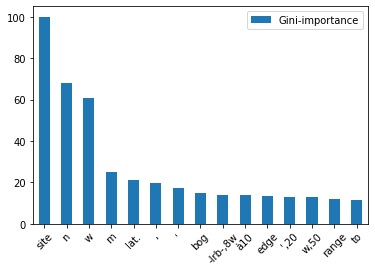

In [75]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False)[:15].plot(kind='bar', rot=45)